In [1]:
from google.cloud import bigquery
from functions import *
# Numpy & Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import warnings

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Set the warning filter to ignore all warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
#import eli5
#from eli5.sklearn import PermutationImportance
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, QuantileTransformer, PowerTransformer, RobustScaler, MaxAbsScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
#import shap
from scipy.stats import chi2_contingency

In [2]:
# set display options to show all columns
pd.set_option('display.max_columns', None)
# Set the float format to display numbers without scientific notation
pd.options.display.float_format = '{:.2f}'.format
# Set the client for future queries to BigQuery
client = bigquery.Client(project = "continente-lced-feup")
#data_table.enable_dataframe_formatter()
#auth.authenticate_user()

In [3]:
!gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=qezTxbKvvGubYB7sPbG4hDGXdRGV9U&access_type=offline&code_challenge=AO67M0nuO6-Uaccf8DaGG-N_-WgPLr-twjHjCKpm3i8&code_challenge_method=S256


Credentials saved to file: [/Users/vp/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "continente-lced-feup" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the r

In [4]:
query = client.query("""
   SELECT *
   FROM 
       tables_staging.df_bold_model
   """)

df = query.result().to_dataframe() # Wait for the job to complete.
df

,CUSTOMER_ACCOUNT_NR_MASK,SUBCAT_CD_EXT,MONTH,YEAR,QUARTER,SEMESTER,CUST_NUM_TRANSACTIONS_MONTH,CUST_NUM_TRANSACTIONS_QUARTER,CUST_NUM_TRANSACTIONS_SEMESTER,CUST_NUM_TRANSACTIONS_YEAR,CUST_TOTAL_QTY_BOUGHT_MONTH,CUST_TOTAL_QTY_BOUGHT_QUARTER,CUST_TOTAL_QTY_BOUGHT_SEMESTER,CUST_TOTAL_QTY_BOUGHT_YEAR,CUST_NUM_UNIQUE_SUBCAT_MONTH,CUST_NUM_UNIQUE_SUBCAT_QUARTER,CUST_NUM_UNIQUE_SUBCAT_SEMESTER,CUST_NUM_UNIQUE_SUBCAT_YEAR,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR,REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUST_AVG_BASKET_SIZE_MONTH,CUST_AVG_BASKET_SIZE_QUARTER,CUST_AVG_BASKET_SIZE_SEMESTER,CUST_AVG_BASKET_SIZE_YEAR,SUBCAT_NUM_TRANSACTIONS_MONTH,SUBCAT_NUM_TRANSACTIONS_QUARTER,SUBCAT_NUM_TRANSACTIONS_SEMESTER,SUBCAT_NUM_TRANSACTIONS_YEAR,SUBCAT_TOTAL_QTY_BOUGHT_MONTH,SUBCAT_TOTAL_QTY_BOUGHT_QUARTER,SUBCAT_TOTAL_QTY_BOUGHT_SEMESTER,SUBCAT_TOTAL_QTY_BOUGHT_YEAR,SUBCAT_NUM_UNIQUE_CUST_MONTH,SUBCAT_NUM_UNIQUE_CUST_QUARTER,SUBCAT_NUM_UNIQUE_CUST_SEMESTER,SUBCAT_NUM_UNIQUE_CUST_YEAR,CUSTSUBCAT_NUM_TRANSACTIONS_MONTH,CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER,CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER,CUSTSUBCAT_NUM_TRANSACTIONS_YEAR,CUSTSUBCAT_TOTAL_QTY_BOUGHT_MONTH,CUSTSUBCAT_TOTAL_QTY_BOUGHT_QUARTER,CUSTSUBCAT_TOTAL_QTY_BOUGHT_SEMESTER,CUSTSUBCAT_TOTAL_QTY_BOUGHT_YEAR,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR,GENDER,FAMILY_MEMBERS,SEG_LIFESTYLE_CD,SEG_LIFESTAGE_CD,CAT_CD_EXT,TARGET
0,9279821,170310,9,2022,3,2,6,15,15,44,50,124,124,400,27,38,38,61,5.20,6.14,6.14,6.23,4.50,7.17,6.80,6.80,7.18,70,251,251,668,105,363,363,873,61,178,178,434,0,0,0,0,0,0,0,0,0.00,0,0,0,F,"(3, 8)",3,5,1703,0
1,11590670,10303,9,2021,3,2,7,17,17,44,46,131,131,370,24,39,39,47,4.83,5.44,5.44,6.09,3.67,5.86,6.41,6.41,6.82,2034,6313,6313,19682,4411,13836,13836,44414,1516,2975,2975,4434,0,1,1,5,0,1,1,5,0.00,0,0,38,F,"(1, 2)",2,2,103,0
2,11590670,30306,9,2021,3,2,7,17,17,44,46,131,131,370,24,39,39,47,4.83,5.44,5.44,6.09,3.67,5.86,6.41,6.41,6.82,80,256,256,596,238,615,615,1297,49,133,133,250,0,0,0,0,0,0,0,0,0.00,0,0,0,F,"(1, 2)",2,2,303,0
3,11912555,140202,9,2021,3,2,8,16,16,44,68,210,210,803,27,55,55,85,2.14,4.60,4.60,5.84,13.50,6.25,9.56,9.56,12.89,215,553,553,1225,436,1206,1206,2666,155,266,266,407,0,0,0,0,0,0,0,0,0.00,0,0,0,F,"(1, 2)",1,4,1402,0
4,13337486,80408,9,2021,3,2,5,15,15,44,91,294,294,1079,38,57,57,77,4.00,5.64,5.64,5.95,5.00,10.60,12.47,12.47,14.07,172,563,563,1772,231,731,731,2323,130,284,284,543,0,0,0,0,0,0,0,0,0.00,0,0,0,F,"(3, 8)",2,4,804,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3365383,87555786,60305,9,2022,3,2,3,13,13,43,33,142,142,465,18,33,33,51,9.50,7.08,7.08,5.71,5.00,8.67,8.08,8.08,8.19,309,1119,1119,2225,404,1499,1499,2974,281,853,853,1451,0,0,0,0,0,0,0,0,0.00,0,0,0,F,"(1, 2)",1,5,603,0
3365384,94050482,50203,9,2021,3,2,6,18,18,43,55,178,178,505,21,50,50,70,3.60,4.59,4.59,6.05,0.00,6.50,6.78,6.78,8.00,1648,5395,5395,13413,2788,9565,9565,21441,1315,2934,2934,4313,0,2,2,7,0,2,2,7,0.00,7,7,33,F,"(1, 2)",1,5,502,1
3365385,295501,10203,9,2022,3,2,2,15,15,44,14,87,87,228,11,40,40,61,27.00,6.50,6.50,6.30,0.00,6.50,5.33,5.33,4.55,490,1392,1392,4511,770,2094,2094,6846,442,992,992,2148,0,0,0,0,0,0,0,0,0.00,0,0,0,F,"(3, 8)",2,4,102,0
3365386,2021880,80110,9,2021,3,2,3,15,15,44,80,330,330,1089,25,43,43,68,7.50,5.50,5.50,6.05,7.00,15.00,11.80,11.80,13.57,1455,4460,4460,14962,3917,12004,12004,39857,1119,2272,2272,3815,0,0,0,1,0,0,0,12,0.00,0,0,0,F,"(1, 2)",1,4,801,0


# Data Preparation

In [5]:
df = df.dropna()
df = df.drop_duplicates()

df['fulldate'] = pd.to_datetime(df['MONTH'].astype(str) + '-' + df['YEAR'].astype(str))
# change from dtype datetime64[ns] to date time month
df['fulldate'] = df['fulldate'].dt.to_period('M')

df_200k = df.groupby('fulldate')#.apply(lambda x: x.drop(columns=['CUSTOMER_ACCOUNT_NR_MASK']))
df_200k = df.groupby('fulldate').sample(frac=1, random_state=101)

#drop customer id column because we want to generalize the model, instead of trying to predict for each customer
df_200k = df_200k.drop(columns=['CUSTOMER_ACCOUNT_NR_MASK'])

In [6]:
df_200k = df_200k[df_200k['SUBCAT_CD_EXT'] == 10101]
df_200k

,SUBCAT_CD_EXT,MONTH,YEAR,QUARTER,SEMESTER,CUST_NUM_TRANSACTIONS_MONTH,CUST_NUM_TRANSACTIONS_QUARTER,CUST_NUM_TRANSACTIONS_SEMESTER,CUST_NUM_TRANSACTIONS_YEAR,CUST_TOTAL_QTY_BOUGHT_MONTH,CUST_TOTAL_QTY_BOUGHT_QUARTER,CUST_TOTAL_QTY_BOUGHT_SEMESTER,CUST_TOTAL_QTY_BOUGHT_YEAR,CUST_NUM_UNIQUE_SUBCAT_MONTH,CUST_NUM_UNIQUE_SUBCAT_QUARTER,CUST_NUM_UNIQUE_SUBCAT_SEMESTER,CUST_NUM_UNIQUE_SUBCAT_YEAR,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR,REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUST_AVG_BASKET_SIZE_MONTH,CUST_AVG_BASKET_SIZE_QUARTER,CUST_AVG_BASKET_SIZE_SEMESTER,CUST_AVG_BASKET_SIZE_YEAR,SUBCAT_NUM_TRANSACTIONS_MONTH,SUBCAT_NUM_TRANSACTIONS_QUARTER,SUBCAT_NUM_TRANSACTIONS_SEMESTER,SUBCAT_NUM_TRANSACTIONS_YEAR,SUBCAT_TOTAL_QTY_BOUGHT_MONTH,SUBCAT_TOTAL_QTY_BOUGHT_QUARTER,SUBCAT_TOTAL_QTY_BOUGHT_SEMESTER,SUBCAT_TOTAL_QTY_BOUGHT_YEAR,SUBCAT_NUM_UNIQUE_CUST_MONTH,SUBCAT_NUM_UNIQUE_CUST_QUARTER,SUBCAT_NUM_UNIQUE_CUST_SEMESTER,SUBCAT_NUM_UNIQUE_CUST_YEAR,CUSTSUBCAT_NUM_TRANSACTIONS_MONTH,CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER,CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER,CUSTSUBCAT_NUM_TRANSACTIONS_YEAR,CUSTSUBCAT_TOTAL_QTY_BOUGHT_MONTH,CUSTSUBCAT_TOTAL_QTY_BOUGHT_QUARTER,CUSTSUBCAT_TOTAL_QTY_BOUGHT_SEMESTER,CUSTSUBCAT_TOTAL_QTY_BOUGHT_YEAR,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR,GENDER,FAMILY_MEMBERS,SEG_LIFESTYLE_CD,SEG_LIFESTAGE_CD,CAT_CD_EXT,TARGET,fulldate
120015,10101,1,2021,1,1,2,2,2,2,60,60,60,60,23,23,23,23,23.00,23.00,23.00,23.00,2.50,24.50,24.50,24.50,24.50,2733,2733,2733,2733,4304,4304,4304,4304,1741,1741,1741,1741,1,1,1,1,2,2,2,2,0.00,0,0,0,F,"(0, 0)",3,4,101,0,2021-01
161893,10101,1,2021,1,1,5,5,5,5,24,24,24,24,15,15,15,15,3.00,3.00,3.00,3.00,12.50,3.20,3.20,3.20,3.20,2733,2733,2733,2733,4304,4304,4304,4304,1741,1741,1741,1741,1,1,1,1,1,1,1,1,0.00,0,0,0,M,"(0, 0)",3,4,101,1,2021-01
553254,10101,1,2021,1,1,5,5,5,5,25,25,25,25,16,16,16,16,2.25,2.25,2.25,2.25,2.17,4.60,4.60,4.60,4.60,2733,2733,2733,2733,4304,4304,4304,4304,1741,1741,1741,1741,0,0,0,0,0,0,0,0,0.00,0,0,0,M,"(3, 8)",1,3,101,1,2021-01
287667,10101,1,2021,1,1,9,9,9,9,50,50,50,50,22,22,22,22,3.00,3.00,3.00,3.00,7.67,4.67,4.67,4.67,4.67,2733,2733,2733,2733,4304,4304,4304,4304,1741,1741,1741,1741,0,0,0,0,0,0,0,0,0.00,0,0,0,F,"(3, 8)",2,4,101,0,2021-01
90077,10101,1,2021,1,1,7,7,7,7,49,49,49,49,13,13,13,13,2.33,2.33,2.33,2.33,5.00,3.14,3.14,3.14,3.14,2733,2733,2733,2733,4304,4304,4304,4304,1741,1741,1741,1741,0,0,0,0,0,0,0,0,0.00,0,0,0,F,"(1, 2)",1,3,101,1,2021-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1713095,10101,11,2022,4,2,7,12,35,70,57,131,406,1025,24,40,51,74,2.50,4.09,3.79,4.54,20.00,6.14,8.33,9.51,12.21,3038,6225,16263,34589,4822,9860,26423,56430,2043,3118,4975,6187,0,0,0,2,0,0,0,2,0.00,0,0,3,F,"(3, 8)",2,4,101,0,2022-11
843520,10101,11,2022,4,2,4,10,25,54,29,104,203,424,15,24,39,51,6.33,6.22,5.83,6.19,7.33,6.00,7.50,5.96,6.04,3038,6225,16263,34589,4822,9860,26423,56430,2043,3118,4975,6187,0,0,0,1,0,0,0,1,0.00,0,0,0,F,"(3, 8)",1,5,101,0,2022-11
822426,10101,11,2022,4,2,2,7,34,81,16,33,199,469,11,20,50,66,17.00,8.00,4.24,4.00,3.25,6.50,4.00,4.41,4.44,3038,6225,16263,34589,4822,9860,26423,56430,2043,3118,4975,6187,0,0,3,10,0,0,3,10,0.00,0,36,29,M,"(1, 2)",2,5,101,1,2022-11
1034974,10101,11,2022,4,2,1,4,7,34,10,36,86,345,6,19,39,60,0.00,14.67,21.00,9.52,7.00,10.00,8.00,10.43,8.65,3038,6225,16263,34589,4822,9860,26423,56430,2043,3118,4975,6187,0,1,1,13,0,2,2,20,0.00,0,0,24,F,"(1, 2)",1,5,101,1,2022-11


In [ ]:
df_200k.value_counts('fulldate').sort_index()

In [ ]:
df_200k.drop(df_200k[(df_200k['CUSTSUBCAT_NUM_TRANSACTIONS_30_DAYS']== 0) & (df_200k['CUSTSUBCAT_NUM_TRANSACTIONS_90_DAYS']== 0) & (df_200k['CUSTSUBCAT_NUM_TRANSACTIONS_180_DAYS']== 0) & (df_200k['CUSTSUBCAT_NUM_TRANSACTIONS_360_DAYS']== 0) & (df_200k['TARGET']== 0)].index, inplace=True)

In [ ]:
columns = ['CUSTSUBCAT_NUM_TRANSACTIONS_30_DAYS',
       'CUSTSUBCAT_NUM_TRANSACTIONS_90_DAYS',
       'CUSTSUBCAT_NUM_TRANSACTIONS_180_DAYS',
       'CUSTSUBCAT_NUM_TRANSACTIONS_360_DAYS']

df_200k = df_200k.drop(columns=columns, axis=1)

In [ ]:
numerical_columns = ['CUST_NUM_TRANSACTIONS_30_DAYS', 'CUST_NUM_TRANSACTIONS_90_DAYS',
       'CUST_NUM_TRANSACTIONS_180_DAYS', 'CUST_NUM_TRANSACTIONS_360_DAYS',
       'CUST_NUM_UNIQUE_SUBCAT_30_DAYS', 'CUST_NUM_UNIQUE_SUBCAT_90_DAYS',
       'CUST_NUM_UNIQUE_SUBCAT_180_DAYS', 'CUST_NUM_UNIQUE_SUBCAT_360_DAYS',
       'CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS',
       'CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_90_DAYS',
       'CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_180_DAYS',
       'CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_360_DAYS',
       'CUST_AVG_BASKET_SIZE_30_DAYS', 'CUST_AVG_BASKET_SIZE_90_DAYS',
       'CUST_AVG_BASKET_SIZE_180_DAYS', 'CUST_AVG_BASKET_SIZE_360_DAYS',
       'SUBCAT_NUM_TRANSACTIONS_30_DAYS', 'SUBCAT_NUM_TRANSACTIONS_90_DAYS',
       'SUBCAT_NUM_TRANSACTIONS_180_DAYS', 'SUBCAT_NUM_TRANSACTIONS_360_DAYS',
       'SUBCAT_NUM_UNIQUE_CUST_30_DAYS', 'SUBCAT_NUM_UNIQUE_CUST_90_DAYS',
       'SUBCAT_NUM_UNIQUE_CUST_180_DAYS', 'SUBCAT_NUM_UNIQUE_CUST_360_DAYS',
       'CUSTSUBCAT_NUM_TRANSACTIONS_30_DAYS',
       'CUSTSUBCAT_NUM_TRANSACTIONS_90_DAYS',
       'CUSTSUBCAT_NUM_TRANSACTIONS_180_DAYS',
       'CUSTSUBCAT_NUM_TRANSACTIONS_360_DAYS',
       'CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS',
       'CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_90_DAYS',
       'CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_180_DAYS',
       'CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_360_DAYS',
       'REG_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS']

#scaler = MinMaxScaler()
scaler = StandardScaler()
df_200k[numerical_columns] = scaler.fit_transform(df_200k[numerical_columns])

In [7]:
numerical_columns = ['CUST_NUM_TRANSACTIONS_MONTH', 'CUST_NUM_TRANSACTIONS_QUARTER',
       'CUST_NUM_TRANSACTIONS_SEMESTER', 'CUST_NUM_TRANSACTIONS_YEAR',
       'CUST_NUM_UNIQUE_SUBCAT_MONTH', 'CUST_NUM_UNIQUE_SUBCAT_QUARTER',
       'CUST_NUM_UNIQUE_SUBCAT_SEMESTER', 'CUST_NUM_UNIQUE_SUBCAT_YEAR',
       'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH',
       'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER',
       'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER',
       'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR',
       'CUST_AVG_BASKET_SIZE_MONTH', 'CUST_AVG_BASKET_SIZE_QUARTER',
       'CUST_AVG_BASKET_SIZE_SEMESTER', 'CUST_AVG_BASKET_SIZE_YEAR',
       'SUBCAT_NUM_TRANSACTIONS_MONTH', 'SUBCAT_NUM_TRANSACTIONS_QUARTER',
       'SUBCAT_NUM_TRANSACTIONS_SEMESTER', 'SUBCAT_NUM_TRANSACTIONS_YEAR',
       'SUBCAT_NUM_UNIQUE_CUST_MONTH', 'SUBCAT_NUM_UNIQUE_CUST_QUARTER',
       'SUBCAT_NUM_UNIQUE_CUST_SEMESTER', 'SUBCAT_NUM_UNIQUE_CUST_YEAR',
       'CUSTSUBCAT_NUM_TRANSACTIONS_MONTH',
       'CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER',
       'CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER',
       'CUSTSUBCAT_NUM_TRANSACTIONS_YEAR',
       'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH',
       'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER',
       'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER',
       'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR',
       'REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH']

scaler = StandardScaler()
##scaler = RobustScaler()
#scaler = MinMaxScaler()
#scaler = PowerTransformer()
#scaler = QuantileTransformer()
df_200k[numerical_columns] = scaler.fit_transform(df_200k[numerical_columns])

## Correlation matrix

In [8]:
def our_heatmap(df_values, threshold=1.1):

    # Define the colors
    colors = ['#84161a', '#fcf2f2']

    # Create a list of relative positions for each color
    positions = [0, 1]

    # Create the custom colormap
    cmap = mcolors.LinearSegmentedColormap.from_list("", list(zip(positions, colors)))

    # keep only the correlations above the threshold
    df_values = df_values[df_values < threshold]

    # Plot the heatmap with the custom colormap
    fig, ax = plt.subplots(figsize=(20, 15))
    sns.heatmap(df_values, annot=True, cmap=cmap, vmin=0, vmax=1)

In [9]:
# calculate correlation matrix
corr = df_200k[numerical_columns].corr()

<AxesSubplot:>

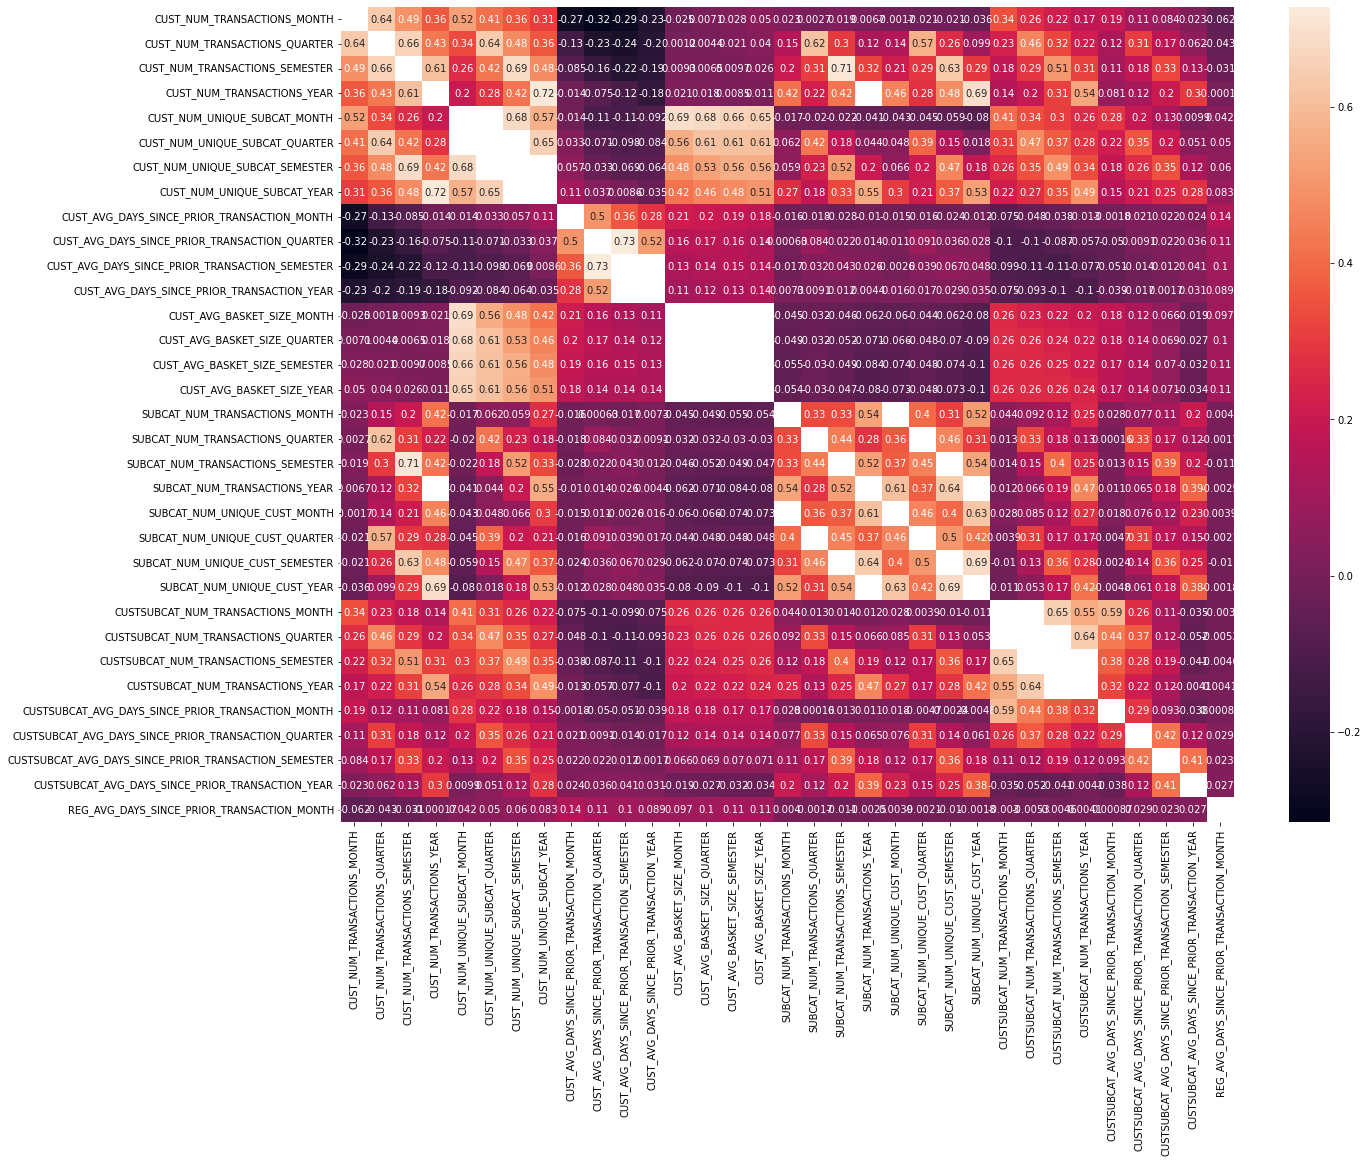

In [10]:
# set the threshold
threshold = 0.75

# keep only the correlations above the threshold
corr = corr[corr < threshold]

# Create the figure and the axes objectsa
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr,annot = True)

In [11]:
# Calculate the correlation matrix
corr = df_200k[numerical_columns].corr()

# Set the threshold
threshold = 0.75

# Filter correlations below the threshold
corr_filtered = corr[corr < threshold]

# Get the list of columns below the threshold
columns_below_threshold = corr_filtered.columns.tolist()

print("Columns below the threshold:")
print(columns_below_threshold)

Columns below the threshold:
['CUST_NUM_TRANSACTIONS_MONTH', 'CUST_NUM_TRANSACTIONS_QUARTER', 'CUST_NUM_TRANSACTIONS_SEMESTER', 'CUST_NUM_TRANSACTIONS_YEAR', 'CUST_NUM_UNIQUE_SUBCAT_MONTH', 'CUST_NUM_UNIQUE_SUBCAT_QUARTER', 'CUST_NUM_UNIQUE_SUBCAT_SEMESTER', 'CUST_NUM_UNIQUE_SUBCAT_YEAR', 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH', 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER', 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER', 'CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR', 'CUST_AVG_BASKET_SIZE_MONTH', 'CUST_AVG_BASKET_SIZE_QUARTER', 'CUST_AVG_BASKET_SIZE_SEMESTER', 'CUST_AVG_BASKET_SIZE_YEAR', 'SUBCAT_NUM_TRANSACTIONS_MONTH', 'SUBCAT_NUM_TRANSACTIONS_QUARTER', 'SUBCAT_NUM_TRANSACTIONS_SEMESTER', 'SUBCAT_NUM_TRANSACTIONS_YEAR', 'SUBCAT_NUM_UNIQUE_CUST_MONTH', 'SUBCAT_NUM_UNIQUE_CUST_QUARTER', 'SUBCAT_NUM_UNIQUE_CUST_SEMESTER', 'SUBCAT_NUM_UNIQUE_CUST_YEAR', 'CUSTSUBCAT_NUM_TRANSACTIONS_MONTH', 'CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER', 'CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER', 'CUSTSUBCA

## Variance Inflation Index

In [12]:
df_200k = df_200k.drop(columns=['QUARTER','SEMESTER','CAT_CD_EXT', 'YEAR', 'MONTH', 'SUBCAT_CD_EXT'], axis=1)

In [13]:
# One-hot encoding categorical variables
df_200k = pd.get_dummies(df_200k, columns=['GENDER','SEG_LIFESTAGE_CD', 'FAMILY_MEMBERS'])
df_200k

,CUST_NUM_TRANSACTIONS_MONTH,CUST_NUM_TRANSACTIONS_QUARTER,CUST_NUM_TRANSACTIONS_SEMESTER,CUST_NUM_TRANSACTIONS_YEAR,CUST_TOTAL_QTY_BOUGHT_MONTH,CUST_TOTAL_QTY_BOUGHT_QUARTER,CUST_TOTAL_QTY_BOUGHT_SEMESTER,CUST_TOTAL_QTY_BOUGHT_YEAR,CUST_NUM_UNIQUE_SUBCAT_MONTH,CUST_NUM_UNIQUE_SUBCAT_QUARTER,CUST_NUM_UNIQUE_SUBCAT_SEMESTER,CUST_NUM_UNIQUE_SUBCAT_YEAR,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER,CUST_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR,REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUST_AVG_BASKET_SIZE_MONTH,CUST_AVG_BASKET_SIZE_QUARTER,CUST_AVG_BASKET_SIZE_SEMESTER,CUST_AVG_BASKET_SIZE_YEAR,SUBCAT_NUM_TRANSACTIONS_MONTH,SUBCAT_NUM_TRANSACTIONS_QUARTER,SUBCAT_NUM_TRANSACTIONS_SEMESTER,SUBCAT_NUM_TRANSACTIONS_YEAR,SUBCAT_TOTAL_QTY_BOUGHT_MONTH,SUBCAT_TOTAL_QTY_BOUGHT_QUARTER,SUBCAT_TOTAL_QTY_BOUGHT_SEMESTER,SUBCAT_TOTAL_QTY_BOUGHT_YEAR,SUBCAT_NUM_UNIQUE_CUST_MONTH,SUBCAT_NUM_UNIQUE_CUST_QUARTER,SUBCAT_NUM_UNIQUE_CUST_SEMESTER,SUBCAT_NUM_UNIQUE_CUST_YEAR,CUSTSUBCAT_NUM_TRANSACTIONS_MONTH,CUSTSUBCAT_NUM_TRANSACTIONS_QUARTER,CUSTSUBCAT_NUM_TRANSACTIONS_SEMESTER,CUSTSUBCAT_NUM_TRANSACTIONS_YEAR,CUSTSUBCAT_TOTAL_QTY_BOUGHT_MONTH,CUSTSUBCAT_TOTAL_QTY_BOUGHT_QUARTER,CUSTSUBCAT_TOTAL_QTY_BOUGHT_SEMESTER,CUSTSUBCAT_TOTAL_QTY_BOUGHT_YEAR,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER,CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR,SEG_LIFESTYLE_CD,TARGET,fulldate,GENDER_F,GENDER_M,SEG_LIFESTAGE_CD_1,SEG_LIFESTAGE_CD_2,SEG_LIFESTAGE_CD_3,SEG_LIFESTAGE_CD_4,SEG_LIFESTAGE_CD_5,SEG_LIFESTAGE_CD_6,"FAMILY_MEMBERS_(0, 0)","FAMILY_MEMBERS_(1, 2)","FAMILY_MEMBERS_(3, 8)"
120015,-1.17,-1.25,-1.31,-1.38,60,60,60,60,0.20,-0.43,-0.82,-1.21,5.47,4.74,4.76,5.14,-0.71,3.51,3.85,4.03,4.24,-0.96,-1.27,-1.51,-1.56,4304,4304,4304,4304,-1.36,-1.51,-1.95,-2.13,0.06,-0.36,-0.57,-0.72,2,2,2,2,-0.45,-0.59,-0.70,-0.79,3,0,2021-01,1,0,0,0,0,1,0,0,1,0,0
161893,-0.18,-0.83,-1.07,-1.25,24,24,24,24,-0.47,-0.93,-1.24,-1.58,-0.57,-0.65,-0.71,-0.76,2.30,-0.79,-0.86,-0.91,-0.97,-0.96,-1.27,-1.51,-1.56,4304,4304,4304,4304,-1.36,-1.51,-1.95,-2.13,0.06,-0.36,-0.57,-0.72,1,1,1,1,-0.45,-0.59,-0.70,-0.79,3,1,2021-01,0,1,0,0,0,1,0,0,1,0,0
553254,-0.18,-0.83,-1.07,-1.25,25,25,25,25,-0.39,-0.87,-1.19,-1.53,-0.79,-0.85,-0.91,-0.98,-0.81,-0.51,-0.55,-0.59,-0.63,-0.96,-1.27,-1.51,-1.56,4304,4304,4304,4304,-1.36,-1.51,-1.95,-2.13,-0.76,-0.80,-0.84,-0.87,0,0,0,0,-0.45,-0.59,-0.70,-0.79,1,1,2021-01,0,1,0,0,1,0,0,0,0,0,1
287667,1.13,-0.26,-0.76,-1.08,50,50,50,50,0.11,-0.49,-0.87,-1.26,-0.57,-0.65,-0.71,-0.76,0.84,-0.49,-0.54,-0.57,-0.61,-0.96,-1.27,-1.51,-1.56,4304,4304,4304,4304,-1.36,-1.51,-1.95,-2.13,-0.76,-0.80,-0.84,-0.87,0,0,0,0,-0.45,-0.59,-0.70,-0.79,2,0,2021-01,1,0,0,0,0,1,0,0,0,0,1
90077,0.47,-0.54,-0.91,-1.17,49,49,49,49,-0.64,-1.05,-1.35,-1.67,-0.77,-0.83,-0.89,-0.95,0.04,-0.80,-0.88,-0.93,-0.98,-0.96,-1.27,-1.51,-1.56,4304,4304,4304,4304,-1.36,-1.51,-1.95,-2.13,-0.76,-0.80,-0.84,-0.87,0,0,0,0,-0.45,-0.59,-0.70,-0.79,1,1,2021-01,1,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1713095,0.47,0.16,1.29,1.55,57,131,406,1025,0.28,0.63,0.65,1.13,-0.72,-0.36,-0.49,-0.30,4.55,-0.20,0.27,0.55,1.23,-0.12,0.10,1.19,1.55,4822,9860,26423,56430,0.05,0.35,1.41,1.47,-0.76,-0.80,-0.84,-0.57,0,0,0,2,-0.45,-0.59,-0.70,-0.68,2,0,2022-11,1,0,0,0,0,1,0,0,0,0,1
843520,-0.51,-0.12,0.50,0.86,29,104,203,424,-0.47,-0.37,0.02,0.07,0.44,0.22,0.06,0.18,0.74,-0.23,0.09,-0.27,-0.27,-0.12,0.10,1.19,1.55,4822,9860,26423,56430,0.05,0.35,1.41,1.47,-0.76,-0.80,-0.84,-0.72,0,0,0,1,-0.45,-0.59,-0.70,-0.79,1,0,2022-11,1,0,0,0,0,0,1,0,0,0,1
822426,-1.17,-0.54,1.21,2.02,16,33,199,469,-0.81,-0.62,0.60,0.76,3.66,0.

In [14]:
# compute the vif for all given features
def compute_vif(considered_features):
    X = df_200k[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    to_keep = vif[vif['VIF'] < 10]
    cols = to_keep['Variable'].tolist()
    
    
    return vif, cols

In [15]:
vif, cols = compute_vif(numerical_columns)

In [16]:
vif.sort_values('VIF', ascending=False)

,Variable,VIF
20,SUBCAT_NUM_UNIQUE_CUST_MONTH,118.02
16,SUBCAT_NUM_TRANSACTIONS_MONTH,100.53
21,SUBCAT_NUM_UNIQUE_CUST_QUARTER,83.84
17,SUBCAT_NUM_TRANSACTIONS_QUARTER,73.66
22,SUBCAT_NUM_UNIQUE_CUST_SEMESTER,43.76
18,SUBCAT_NUM_TRANSACTIONS_SEMESTER,34.82
6,CUST_NUM_UNIQUE_SUBCAT_SEMESTER,26.73
23,SUBCAT_NUM_UNIQUE_CUST_YEAR,23.64
14,CUST_AVG_BASKET_SIZE_SEMESTER,22.89
5,CUST_NUM_UNIQUE_SUBCAT_QUARTER,21.65


In [17]:
num = ['SEG_LIFESTYLE_CD', 'GENDER_F', 'GENDER_M', 'SEG_LIFESTAGE_CD_1',
       'SEG_LIFESTAGE_CD_2', 'SEG_LIFESTAGE_CD_3', 'SEG_LIFESTAGE_CD_4',
       'SEG_LIFESTAGE_CD_5', 'SEG_LIFESTAGE_CD_6', 'FAMILY_MEMBERS_(0, 0)',
       'FAMILY_MEMBERS_(1, 2)', 'FAMILY_MEMBERS_(3, 8)', 'fulldate']

df_200k = df_200k[cols + num]

In [ ]:
df_200k = df_200k.drop('TARGET', axis=1)

In [ ]:
df_200k = df_200k.drop(columns=['CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_QUARTER','CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_SEMESTER',
                                'CUSTSUBCAT_AVG_DAYS_SINCE_PRIOR_TRANSACTION_YEAR'])

In [ ]:
df_200k = df_200k[columns_below_threshold + num]
df_200k

# Machine Learning

In [18]:
results_df = pd.DataFrame()

In [ ]:
def random_oversampling(x_train,y_train):
    ros = RandomOverSampler(random_state=101)
    X_train, y_train = ros.fit_resample(x_train, y_train)
    
    return X_train, y_train

def roSMOTE(x_train,y_train):
    os = SMOTE(random_state=101)
    X_train, y_train = os.fit_resample(x_train, y_train)
    y_train = y_train.astype(np.float64)
    X_train = y_train.astype(np.float64)
    return X_train, y_train

def random_undersampling(x_train,y_train):
    rus = RandomUnderSampler(random_state=101)
    X_train, y_train = rus.fit_resample(x_train, y_train)
    
    return X_train, y_train

In [19]:
def reg_metrics(pred_model, x_train, x_test, y_train, y_test):
    """ Function takes in training and testing sets, prediction model, 
    and ouputs the below metrics:
    1. R² or Coefficient of Determination.
    2. Adjusted R²
    3. Mean Squared Error(MSE)
    4. Root-Mean-Squared-Error(RMSE).
    5. Mean-Absolute-Error(MAE).
    """
    global r2
    global adj_r2
    global mse
    global rmse
    global mae
    
    # Get predicted values on x_test
    y_pred = pred_model.predict(x_test)

    #1 & 2 Coefficient of Determination (R² & Adjusted R²)
    print("\n\t--- Coefficient of Determination (R² & Adjusted R²) ---")
    r2 = metrics.r2_score(y_pred=y_pred, y_true=y_test)
    adj_r2 = 1 - (1-r2)*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)

    print(f"R²\t\t: {r2:.2f}")
    print(f"Adjusted R²\t: {adj_r2:.2f}")

    #3 & 4. MSE and RMSE
    print("\n\t--- Mean Squared Error (MSE & RMSE) ---")
   
    mse = metrics.mean_squared_error(y_pred=y_pred, y_true=y_test, squared=True)
    rmse = metrics.mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False)
    
    print(f"MSE\t: {mse:.2f}")
    print(f"RMSE\t: {rmse:.2f}")

    #5. MAE
    print("\n\t--- Mean Absolute Error (MAE) ---")
    mae = metrics.mean_absolute_error(y_pred=y_pred, y_true=y_test)
    print(f"RMSE\t: {mae:.2f}")
    
    # # Return Accuracy
    # #train_acc = "{:.2f}".format(pred_model.score(x_train, y_train)*100)
    # #test_acc = "{:.2f}".format(pred_model.score(x_test, y_test)*100)
    
    # #Convert variables to a rounded format 
    # r2_formatted = "{:.2f}%".format(r2 * 100)
    # adj_r2_formatted = "{:.2f}%".format(adj_r2 * 100)
    # mse_formatted = "{:.2f}".format(mse)
    # rmse_formatted = "{:.2f}".format(rmse)
    # mae_formatted = "{:.2f}".format(mae)
    
    # # Return metrics as a dictionary
    # metrics_dict = {
    #     'R²': r2_formatted,
    #     'Adjusted R²': adj_r2_formatted,
    #     'MSE': mse_formatted,
    #     'RMSE': rmse_formatted,
    #     'MAE': mae_formatted
    # }
    
    #return metrics_dict

In [ ]:
def cross_val_reg(df_ML, model, resampling_tecnique, model_name):
    global results_df
    print(f'\t------- {model_name} -------\n')

    timestamps = df_ML['fulldate'].sort_values().unique()

    # store each of the metrics in an array for each one
    rsquared_array = np.array([])
    adjrsquared_array = np.array([])
    mse_array = np.array([])
    rmse_array = np.array([])
    mae_array = np.array([])

    i = 0
    ii = 1
    max_timestamp = timestamps.max() - 2
    while timestamps[i] < max_timestamp:
            print('\n')
            print('-' * 50)
            print(f'\n\n\t---- Start Iteration {ii} ----\n')
            print("\n\t----- Iteration Info -----")
            print(f'\nTreino feito com os meses: {timestamps[i]} até {timestamps[i]+2}') # 11   
            train = df_ML[df_ML['fulldate'].isin([timestamps[i], timestamps[i]+1, timestamps[i]+2])]
            print(f'Teste feito com o mês: {timestamps[i]+3}\n')

            # test and train split
            train_tune = train.groupby('fulldate').sample(frac=0.3, random_state=101)
            train_tune.value_counts('fulldate').sort_index()
            X_train_cv = train.drop(['REG_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS','fulldate'], axis=1)
            y_train_cv = train['REG_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS'].astype(int)
            y_train_cv.value_counts('fulldate').sort_index()
            X_train_tune = train_tune.drop(['REG_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS','fulldate'], axis=1)
            y_train_tune = train_tune['REG_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS'].astype(int)
            y_train_tune.value_counts('fulldate').sort_index() 
                           
            # resampling technique
            X_train_cv, y_train_cv = resampling_tecnique(X_train_cv, y_train_cv)
            X_train_tune, y_train_tune = random_undersampling(X_train_tune, y_train_tune)

            print('X_train_cv shape: ', X_train_cv.shape)
            print('X_train_tune shape: ', X_train_tune.shape)
            
            test = df_ML[df_ML['fulldate'] == timestamps[i]+3] # 12
            
            X_test = test.drop(['REG_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS', 'fulldate'], axis=1)
            #X_test.value_counts('fulldate').sort_index() 
            y_test = test['REG_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS'].astype(int)
            y_test.value_counts('fulldate').sort_index() 
            print('X_test shape: ', X_test.shape)
            print('\n\t--------------------------')
            # predictions for metrics
            y_pred = model(X_train_cv, y_train_cv, X_train_tune, y_train_tune, X_test, y_test)
            
            #append rsquared to rsquared_array
            rsquared_array = np.append(rsquared_array, r2)
            #append adjrsquared to ajdrsquared_array
            adjrsquared_array = np.append(adjrsquared_array, adj_r2)
            #append mse to mse_array
            mse_array = np.append(mse_array, mse)
            #append rmse to rmse_array
            rmse_array = np.append(rmse_array, mse)
            #append mae to mae_array
            mae_array = np.append(mae_array, mae)
            
            i += 1
            ii += 1
    else:
        print('\n----------------------------\n\n')
        print(f'R² Mean of all iterations : {np.mean(rsquared_array)}')
        print(f'Adjusted R² Mean of all iterations : {np.mean(adjrsquared_array)}')
        print(f'MSE Mean of all iterations: {np.mean(mse_array)}')
        print(f'RMSE mean of all iterations: {np.mean(rmse_array)}')
        print(f'MAE mean of all iterations: {np.mean(mae_array)}')

        # Append the results to the dataframe
        results_df = results_df.append({
        'Model': model_name,  # Replace 'Model Name' with the actual model name
        'R² Mean': np.mean(rsquared_array),
        'Adjusted R² Mean': np.mean(adjrsquared_array),
        'MSE Mean': np.mean(mse_array),
        'RMSE Mean': np.mean(rmse_array),
        'MAE Mean': np.mean(mae_array)}, ignore_index=True)
        
    return X_train_cv, y_train_cv,X_test, y_test, y_pred, results_df 



In [20]:
def cross_val_reg(df_ML, model, model_name):
    global results_df
    print(f'\t------- {model_name} -------\n')

    timestamps = df_ML['fulldate'].sort_values().unique()

    # store each of the metrics in an array for each one
    rsquared_array = np.array([])
    adjrsquared_array = np.array([])
    mse_array = np.array([])
    rmse_array = np.array([])
    mae_array = np.array([])

    i = 0
    ii = 1
    max_timestamp = timestamps.max() - 2
    while timestamps[i] < max_timestamp:
            print('\n')
            print('-' * 50)
            print(f'\n\n\t---- Start Iteration {ii} ----\n')
            print("\n\t----- Iteration Info -----")
            print(f'\nTreino feito com os meses: {timestamps[i]} até {timestamps[i]+2}') # 11   
            train = df_ML[df_ML['fulldate'].isin([timestamps[i], timestamps[i]+1, timestamps[i]+2])]
            print(f'Teste feito com o mês: {timestamps[i]+3}\n')

            # test and train split
            train_tune = train.groupby('fulldate').sample(frac=0.3, random_state=101)
            train_tune.value_counts('fulldate').sort_index()
            X_train_cv = train.drop(['REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH','fulldate'], axis=1)
            y_train_cv = train['REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'].astype(int)
            y_train_cv.value_counts('fulldate').sort_index()
            X_train_tune = train_tune.drop(['REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH','fulldate'], axis=1)
            y_train_tune = train_tune['REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'].astype(int)
            y_train_tune.value_counts('fulldate').sort_index() 
                           
            # resampling technique
            #X_train_cv, y_train_cv = resampling_tecnique(X_train_cv, y_train_cv)
            #X_train_tune, y_train_tune = random_undersampling(X_train_tune, y_train_tune)

            print('X_train_cv shape: ', X_train_cv.shape)
            print('X_train_tune shape: ', X_train_tune.shape)
            
            test = df_ML[df_ML['fulldate'] == timestamps[i]+3] # 12
            
            X_test = test.drop(['REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH', 'fulldate'], axis=1)
            #X_test.value_counts('fulldate').sort_index() 
            y_test = test['REG_AVG_DAYS_SINCE_PRIOR_TRANSACTION_MONTH'].astype(int)
            y_test.value_counts('fulldate').sort_index() 
            print('X_test shape: ', X_test.shape)
            print('\n\t--------------------------')
            # predictions for metrics
            y_pred = model(X_train_cv, y_train_cv, X_train_tune, y_train_tune, X_test, y_test)
            
            #append rsquared to rsquared_array
            rsquared_array = np.append(rsquared_array, r2)
            #append adjrsquared to ajdrsquared_array
            adjrsquared_array = np.append(adjrsquared_array, adj_r2)
            #append mse to mse_array
            mse_array = np.append(mse_array, mse)
            #append rmse to rmse_array
            rmse_array = np.append(rmse_array, mse)
            #append mae to mae_array
            mae_array = np.append(mae_array, mae)
            
            i += 1
            ii += 1
    else:
        print('\n----------------------------\n\n')
        print(f'R² Mean of all iterations : {np.mean(rsquared_array)}')
        print(f'Adjusted R² Mean of all iterations : {np.mean(adjrsquared_array)}')
        print(f'MSE Mean of all iterations: {np.mean(mse_array)}')
        print(f'RMSE mean of all iterations: {np.mean(rmse_array)}')
        print(f'MAE mean of all iterations: {np.mean(mae_array)}')

        # Append the results to the dataframe
        results_df = results_df.append({
        'Model': model_name,  # Replace 'Model Name' with the actual model name
        'R² Mean': np.mean(rsquared_array),
        'Adjusted R² Mean': np.mean(adjrsquared_array),
        'MSE Mean': np.mean(mse_array),
        'RMSE Mean': np.mean(rmse_array),
        'MAE Mean': np.mean(mae_array)}, ignore_index=True)
        
    return X_train_cv, y_train_cv,X_test, y_test, y_pred, results_df 



In [ ]:
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
    'feature_importance': importances}).sort_values('feature_importance', ascending = False).reset_index(drop = True)
    return df

In [ ]:
def LR(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    clf = Pipeline([
        # ('pca', PCA()),
        ('clf', LinearRegression())
    ])

    param_grid = {}
    


    #fs = SelectKBest(score_func=f_regression, k=10)
    # apply feature selection
    #X_selected = fs.fit(X_train_tune, y_train_tune)
    #X_test = X_selected.transform(X_test)
    #X_train = X_selected.transform(X_train)
    #names = list(X_selected.feature_names_in_)
    #print('\n\nNumber of selected features: {}'.format(names))
    # Use SequentialFeatureSelector for forward/backward selection
    #sfs_backward = SequentialFeatureSelector(clf, n_features_to_select=None, direction='backward', scoring='r2', cv=None, n_jobs=-1)  # Does 5-Fold CV

    sfs1 = sfs(clf['clf'], k_features=15, forward=True, verbose=2, scoring='neg_mean_squared_error')
    sfs1 = sfs1.fit(X_train_tune, y_train_tune)

    # Fit the feature selector to the training data
    #sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs1.transform(X_train)
    X_train = pd.DataFrame(X_train)
    X_test = sfs1.transform(X_test)
    print(f'X_train Shape: {X_train.shape}')

    #print('\n\nNumber of selected features: {}'.format(sfs_backward.n_features_to_select_))
    #print('Features selected: {}'.format(sfs_backward.feature_names_in_[sfs_backward.support_]))
    feat_names = list(sfs1.k_feature_names_)
    print('\n\nNumber of selected features: {}'.format(feat_names))

    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='r2', cv=2, verbose=1, n_jobs=-1)
    LR = Pipeline([('gs', gs)])

    LR.fit(X_train, y_train)
        
    # # create permutation importance object using model
    # # and fit on test set
    # perm = PermutationImportance(LR, random_state=1).fit(X_test, y_test)
    
    # # display weights using PermutationImportance object
    # eli5.show_weights(perm)
    # perm = PermutationImportance(LR, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)
    # perm_imp_eli5 = imp_df(X_train.columns, perm.feature_importances_)
    # Calculate permutation importances
    # perm = PermutationImportance(LR, X_train, y_train)

    # # Create a DataFrame to store the importances
    # perm_imp_eli5 = pd.DataFrame({'Feature': X_train.columns, 'Importance': perm.importances_mean})

    # Display the importances
    #print(perm_imp_eli5)
    
    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = LR.named_steps['gs'].best_estimator_['clf']

    # Get feature importances (coefficients)
    feature_importances = final_estimator.coef_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.10f' % (i, v))

    # # plot feature importance
    # plt.bar([x for x in range(len(feature_importances))], feature_importances)
    # plt.show()
    print('\n---------------------\n')
    reg_metrics(LR, X_train, X_test, y_train, y_test)


In [21]:
def LR(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    clf = Pipeline([
        # ('pca', PCA()),
        ('clf', LinearRegression())
    ])

    param_grid = {}

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(clf, n_features_to_select='auto', direction='forward',
                                             scoring='neg_mean_squared_error', cv=None, n_jobs=-1)  # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)
    print(f'X_train Shape: {X_train.shape}')

    print('\n\nNumber of selected features: {}'.format(sfs_backward.n_features_to_select_))
    #print('Features selected: {}'.format(sfs_backward.feature_names_in_[sfs_backward.support_]))

    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='r2', cv=2, verbose=1, n_jobs=-1)
    LR = Pipeline([('gs', gs)])

    LR.fit(X_train, y_train)
    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = LR.named_steps['gs'].best_estimator_['clf']

    # Get feature importances (coefficients)
    feature_importances = final_estimator.coef_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.20f' % (i, v))

    print('\n------------------------------')
    reg_metrics(LR, X_train, X_test, y_train, y_test)


In [25]:
def ridge(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    clf = Pipeline([
                # ('pca', PCA()),
                ('clf', Ridge(max_iter=1000, tol=11.830e-06))])  

    param_grid = {
    'clf__alpha': (np.arange(0.001,1.0,0.001))}
    #'clf__alpha': [0.01]}

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(clf['clf'], n_features_to_select=0.5, direction='forward', scoring='r2', cv=None, n_jobs=-1) # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)

    print('Number of selected features: {}'.format(sfs_backward.n_features_to_select_))
    #print('Features selected: {}'.format(sfs_backward.feature_names_in_[sfs_backward.support_]))
        
    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='r2', cv=2, verbose=1, n_jobs=-1)
    RG = Pipeline([('gs', gs)]) 
        
    RG.fit(X_train,y_train)
    
    # get best parameters
    best_params = gs.best_params_
    print('\n')
    print('-' * 60)
    print('Best Parameters:')
    print(best_params)
    print('-' * 60)
    print('\n')

    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = RG.named_steps['gs'].best_estimator_['clf']

    # Get feature importances (coefficients)
    feature_importances = final_estimator.coef_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.20f' % (i, v))

    print('\n------------------------------')

    reg_metrics(RG, X_train, X_test, y_train, y_test)

In [26]:
def lasso(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    clf = Pipeline([
                # ('pca', PCA()),
                ('clf', Lasso(max_iter=1000, tol=11.830e-06))])  

    param_grid = {
    'clf__alpha': (np.arange(0.001,1.0,0.001))}

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(clf, n_features_to_select=0.5, direction='forward', scoring='r2', cv=None, n_jobs=-1) # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)


    print('Number of selected features: {}'.format(sfs_backward.n_features_to_select_))
    #print('Features selected: {}'.format(sfs_backward.feature_names_in_[sfs_backward.support_])
    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='r2', cv=2, verbose=1, n_jobs=-1)
    LS = Pipeline([('gs', gs)]) 
        
    LS.fit(X_train,y_train)

    # get best parameters
    best_params = gs.best_params_
    print('\n')
    print('-' * 60)
    print('Best Parameters:')
    print(best_params)
    print('-' * 60)
    print('\n')

    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = LS.named_steps['gs'].best_estimator_['clf']

    # Get feature importances (coefficients)
    feature_importances = final_estimator.coef_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.20f' % (i, v))

    print('\n------------------------------')

    reg_metrics(LS, X_train, X_test, y_train, y_test)


In [27]:
def ElasticNetRegression(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    clf = Pipeline([
        # ('pca', PCA()),
        ('clf', ElasticNet(max_iter=10000,tol=11.830e-06))])

    param_grid = {
        'clf__alpha': (np.arange(0.001,1.0,0.001))
    }

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(
        clf['clf'], n_features_to_select=0.5, direction='forward', scoring='neg_mean_squared_error', cv=None,
        n_jobs=-1)  # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)

    print('Number of selected features: {}'.format(sfs_backward.n_features_to_select_))

    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=2, verbose=1,
                      n_jobs=-1)
    EN = Pipeline([('gs', gs)])

    EN.fit(X_train, y_train)

    best_params = gs.best_params_
    print('\n')
    print('-' * 60)
    print('Best Parameters:')
    print(best_params)
    print('-' * 60)
    print('\n')
    
    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = EN.named_steps['gs'].best_estimator_['clf']

    # Get feature importances (coefficients)
    feature_importances = final_estimator.coef_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.20f' % (i, v))

    print('\n------------------------------')

    reg_metrics(EN, X_train, X_test, y_train, y_test)

In [35]:
def gradientboostingreg(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    clf = Pipeline([
    # ('pca', PCA()),
    ('clf', GradientBoostingRegressor())])

    param_grid = {
        'clf__alpha': (np.arange(0.001,1.0,0.005))
    }

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(
        clf['clf'], n_features_to_select='auto', direction='forward', scoring='r2', cv=None,
        n_jobs=-1)  # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)

    print('Number of selected features: {}'.format(sfs_backward.n_features_to_select_))

    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='r2', cv=2, verbose=1,
                      n_jobs=-1)
    GB = Pipeline([('gs', gs)])

    GB.fit(X_train, y_train)

    best_params = gs.best_params_
    print('\n')
    print('-' * 60)
    print('Best Parameters:')
    print(best_params)
    print('-' * 60)
    print('\n')
    
    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = GB.named_steps['gs'].best_estimator_['clf']

    # Get feature importances
    feature_importances = final_estimator.feature_importances_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.20f' % (i, v))

    print('\n------------------------------')

    reg_metrics(GB, X_train, X_test, y_train, y_test)

In [38]:
def randomforestreg(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    clf = Pipeline([
    # ('pca', PCA()),
    ('clf', RandomForestRegressor())])

    param_grid = {
        'clf__min_samples_split': (range(1,30,1)),
        'clf__min_samples_leaf': (range(1,30,1))
    }

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(
        clf['clf'], n_features_to_select='auto', direction='forward', scoring='r2', cv=None,
        n_jobs=-1)  # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)

    print('Number of selected features: {}'.format(sfs_backward.n_features_to_select_))

    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='r2', cv=2, verbose=1,
                      n_jobs=-1)
    RF = Pipeline([('gs', gs)])

    RF.fit(X_train, y_train)

    best_params = gs.best_params_
    print('\n')
    print('-' * 60)
    print('Best Parameters:')
    print(best_params)
    print('-' * 60)
    print('\n')
    
    print('\n------- IMPORTANCE --------')
    # Get the final estimator from the pipeline
    final_estimator = RF.named_steps['gs'].best_estimator_['clf']

    # Get feature importances
    feature_importances = final_estimator.feature_importances_

    # Summarize feature importance
    for i, v in enumerate(feature_importances):
        print('Feature: %0d, Score: %.20f' % (i, v))

    print('\n------------------------------')

    reg_metrics(RF, X_train, X_test, y_train, y_test)

In [30]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, LR, 'Linear Regression')

	------- Linear Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2885, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (991, 26)

	--------------------------
X_train Shape: (2885, 13)


Number of selected features: 13
Fitting 2 folds for each of 1 candidates, totalling 2 fits

------- IMPORTANCE --------
Feature: 0, Score: -0.03539607089760583164
Feature: 1, Score: 0.01492356083410572611
Feature: 2, Score: 0.01514397528451062909
Feature: 3, Score: 0.01631734400285084208
Feature: 4, Score: -0.00208645405519534239
Feature: 5, Score: -0.00126604642408923622
Feature: 6, Score: -0.00071678026338843702
Feature: 7, Score: -0.01508887306299081660
Feature: 8, Score: 0.56515929706040823888
Feature: 9, Score: -0.07524839671685426556
Feature: 10, Score: -0.00315015599840952820
Feature: 11, Score: 0.115645260566944

In [31]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, ridge, 'Ridge Regression')

	------- Ridge Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2885, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (991, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 999 candidates, totalling 1998 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.999}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: -0.03527451814417453119
Feature: 1, Score: 0.01492436131715476136
Feature: 2, Score: 0.01514478759038948019
Feature: 3, Score: 0.01631821924684497341
Feature: 4, Score: -0.00162824291521559343
Feature: 5, Score: -0.00098800695625103152
Feature: 6, Score: -0.00055936644405931986
Feature: 7, Score: -0.00168260252713272511
Feature: 8, Score: -0.015

In [32]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, lasso, 'Lasso Regression')

	------- Lasso Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2885, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (991, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 999 candidates, totalling 1998 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.016}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: -0.02471949657345929793
Feature: 1, Score: 0.01427122781208587342
Feature: 2, Score: 0.00000000000000000000
Feature: 3, Score: 0.00000000000000000000
Feature: 4, Score: 0.02435487585503752841
Feature: 5, Score: 0.00000000000000000000
Feature: 6, Score: -0.00000000000000000000
Feature: 7, Score: -0.00000000000000000000
Feature: 8, Score: -0.00000

In [33]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, ElasticNetRegression, 'ElasticNet Regression')

	------- ElasticNet Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2885, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (991, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 999 candidates, totalling 1998 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.032}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: -0.02447479855369687901
Feature: 1, Score: 0.01433291189263781809
Feature: 2, Score: 0.00000000000000000000
Feature: 3, Score: 0.00000000000000000000
Feature: 4, Score: 0.02402879825037755601
Feature: 5, Score: 0.00000000000000000000
Feature: 6, Score: -0.00000000000000000000
Feature: 7, Score: -0.00000000000000000000
Feature: 8, Score: -0.

In [36]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, gradientboostingreg, 'Gradient Boosting Regression')

	------- Gradient Boosting Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2885, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (991, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 200 candidates, totalling 400 fits


------------------------------------------------------------
Best Parameters:
{'clf__alpha': 0.736}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 0.12376304689713206464
Feature: 1, Score: 0.26850873250736401188
Feature: 2, Score: 0.09404256078780068306
Feature: 3, Score: 0.04140062088152061254
Feature: 4, Score: 0.03115675623936416117
Feature: 5, Score: 0.03284853761583893250
Feature: 6, Score: 0.01359476226334294623
Feature: 7, Score: 0.07162950885235377929
Feature: 8, Score: 

In [39]:
X_train_cv, y_train_cv,X_test, y_test, y_pred, results = cross_val_reg(df_200k, randomforestreg, 'Random Forest Regression')

	------- Random Forest Regression -------



--------------------------------------------------


	---- Start Iteration 1 ----


	----- Iteration Info -----

Treino feito com os meses: 2021-01 até 2021-03
Teste feito com o mês: 2021-04

X_train_cv shape:  (2885, 26)
X_train_tune shape:  (866, 26)
X_test shape:  (991, 26)

	--------------------------
Number of selected features: 13
Fitting 2 folds for each of 841 candidates, totalling 1682 fits


------------------------------------------------------------
Best Parameters:
{'clf__min_samples_leaf': 29, 'clf__min_samples_split': 18}
------------------------------------------------------------



------- IMPORTANCE --------
Feature: 0, Score: 0.18951563872607568584
Feature: 1, Score: 0.24528077814915089094
Feature: 2, Score: 0.07214763979060970223
Feature: 3, Score: 0.07040772830479369304
Feature: 4, Score: 0.00000000000000000000
Feature: 5, Score: 0.00137507729553034623
Feature: 6, Score: 0.05058605015987550219
Feature: 7, Score: 0.09175

In [45]:
print(results.to_string(index=False), end=' ')

                       Model  R² Mean  Adjusted R² Mean  MSE Mean  RMSE Mean  MAE Mean
           Linear Regression     0.01              0.01      0.55       0.55      0.36
            Ridge Regression     0.01              0.01      0.55       0.55      0.36
            Lasso Regression     0.01              0.01      0.55       0.55      0.35
       ElasticNet Regression     0.01              0.01      0.55       0.55      0.35
Gradient Boosting Regression     0.00             -0.00      0.55       0.55      0.36
    Random Forest Regression     0.01              0.00      0.55       0.55      0.36 